In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*
mne.set_log_level('CRITICAL')

In [102]:

erp_times = create_erp_times(-0.5,0.5, 128)
ep_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz_corrected'
mapchange_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected_since'

## Individual subject plot

In [90]:
sub = '05'
period = 'post'
ch_to_plot = 'Cz'


time_to_plot = 0.1
time_idx = time_index_custom([time_to_plot], erp_times)[0]



#read epochs data
ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
eps = mne.read_epochs(ep_file).get_data()

#read mapchange data
mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
mapchange_df = pd.read_csv(mapchange_file)
mapchange_df_firsts = mapchange_df.query('type =="first"')
mapchange_df_others = mapchange_df.query('type =="other"')

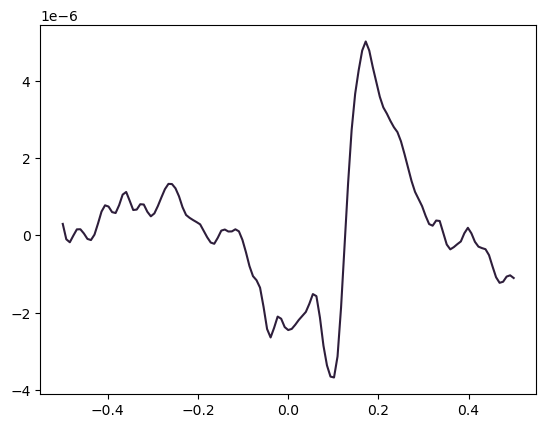

In [91]:
plt.plot(erp_times,eps[:, 47, :].mean(axis = 0))

ValueError: x and y must be the same size

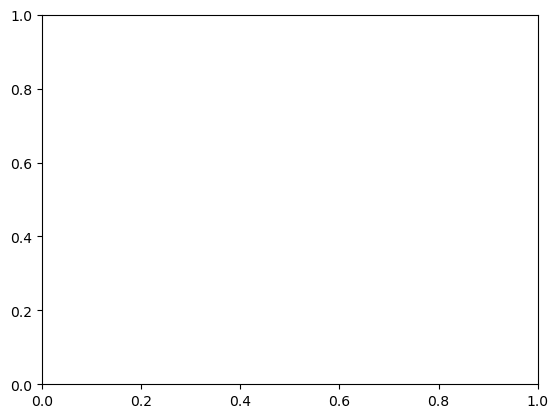

In [92]:
for i, row in mapchange_df_firsts.iterrows():
    keystroke_idx = row['keystroke_idx']
    jitter_x = row['prev_keystrokes'] + np.random.uniform(-0.2, 0.2)
    #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'orange', marker = 'x', alpha = 0.4)
    plt.scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'orange', marker = 'x', alpha = 0.4)



for i, row in mapchange_df_others.iterrows():
    keystroke_idx = row['keystroke_idx']
    jitter_x = -1 + np.random.uniform(-0.2, 0.2)
    #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'brown', marker = 'x', alpha = 0.4)
    plt.scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'brown', marker = 'x', alpha = 0.4)

#plt.hlines(0,0,max(mapchange_df_firsts['prev_keystrokes']), color = 'black')
plt.ylabel('Amplitude')
plt.xlabel('Keystrokes before map change')
plt.title(f'Amplitude at {time_to_plot} s of first and other keystrokes, {ch_to_plot} sub {sub} {period}')


### Violin plot all data

In [ ]:
#violin plot data prep
ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']
ch_idx = ch_index(ch_to_plot)
period = 'pre'

# Initialize figure
#plt.figure(figsize = (12,6))

# Store the data for violin plot
firsts_y = []
firsts_x = []
others_y = []
others_x = []


# Loop over subjects
col = 'orange'
for k, sub in enumerate(subjects_to_process):

    # Read epochs data
    ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
    eps = mne.read_epochs(ep_file).get_data()

    # Read mapchange data
    mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
    mapchange_df = pd.read_csv(mapchange_file)
    mapchange_df_firsts = mapchange_df.query('type =="first"')
    mapchange_df_others = mapchange_df.query('type =="other"')

    # Collect the data for violin plot (you can collect `eps` or specific values)
    for i, row in mapchange_df_firsts.iterrows():
        try:
            keystroke_idx = row['keystroke_idx']
            jitter_x = row['prev_keystrokes'] + np.random.uniform(-0.2, 0.2)
            amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
          #  plt.scatter(jitter_x, amp, color='orange', marker='x', alpha=0.4)

            firsts_y.append(amp) 
            firsts_x.append(row['prev_keystrokes'])

        except IndexError: 
            print(f'failed to plot {sub}')
            continue

    for i, row in mapchange_df_others.iterrows():
        try:
            keystroke_idx = row['keystroke_idx']
            jitter_x = -1 + np.random.uniform(-0.2, 0.2)

            amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
         #   plt.scatter(jitter_x, amp, color='brown', marker='x', alpha=0.4)

            others_x.append(-1.0)
            others_y.append(amp) 
            
        except IndexError:
            print(f'failed to plot {sub}')
            continue 


In [ ]:
#violin plot bins

#bin x axis
n_bins = 2
firsts_xcut = pd.cut(firsts_x, n_bins)
bin_centers = [interval.mid for interval in firsts_xcut.categories]
x_labels = [f"{x:.1f}" for x in bin_centers]
firsts_x = np.array(firsts_x)


# Define the number of bins and the range of the data
n_bins = 2

# Create the bins using pd.cut with the logarithmic edges 
firsts_xcut = pd.cut(firsts_x, bins=[0, 1,2, 3,4, 5,30]) #or make it an equal number of bins with nbins

# Calculate the bin centers
bin_centers = [interval.mid for interval in firsts_xcut.categories]

# Format the labels
x_labels = [f"{x:.1f}" for x in bin_centers]

# Print the results (optional)
# print("Bin edges:", log_edges)
# print("Bin centers:", bin_centers)
# print("Labels:", x_labels)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-c

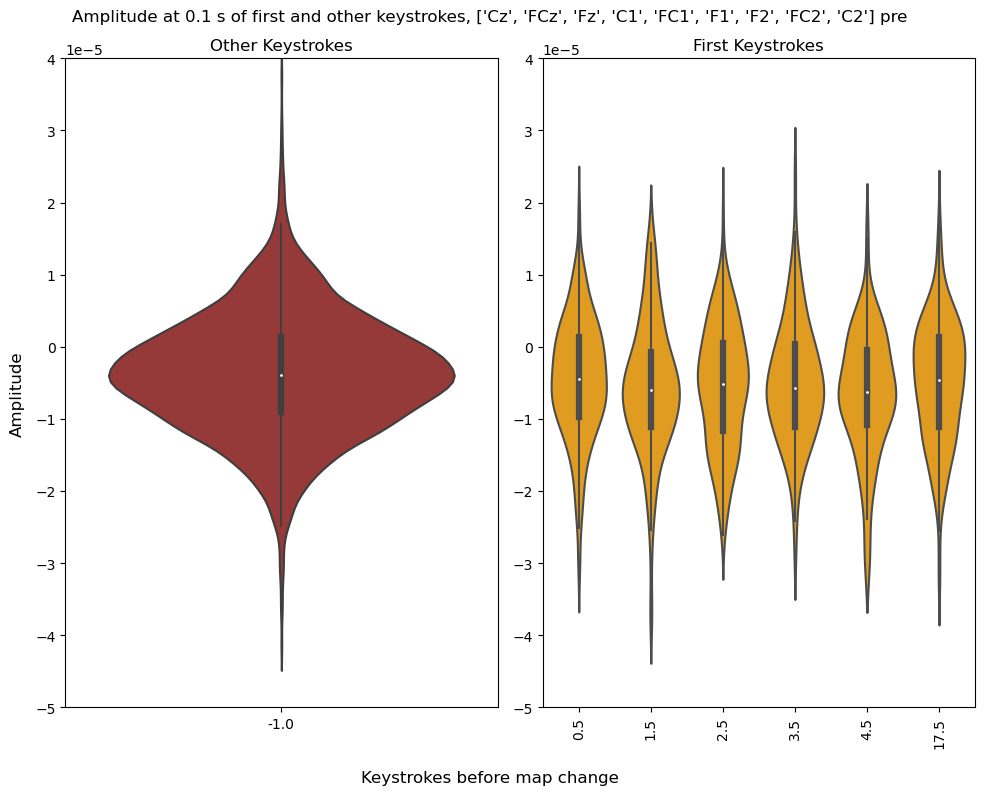

In [ ]:

fig, axes = plt.subplots(1,2, figsize = (10,8))

# Create the violin plot, aligning it with the scatter plot
sns.violinplot(x=firsts_xcut, y=firsts_y, color='orange', ax = axes[1])
sns.violinplot(x=others_x, y=others_y, color='brown', ax = axes[0])
# sns.stripplot(x=firsts_xcut, y=firsts_y, color='grey', ax = axes[1], alpha = 0.4)
# sns.stripplot(x=others_x, y=others_y, color='grey', ax = axes[0],alpha = 0.4)


plt.setp(axes, ylim=(-0.00005, 0.00004))

# Add titles to each subplot
axes[0].set_title('Other Keystrokes', fontsize=12)
axes[1].set_title('First Keystrokes', fontsize=12)
axes[1].set_xticklabels(labels = x_labels, rotation= 90)

# Customize plot
fig.supylabel('Amplitude')
fig.supxlabel('Keystrokes before map change')
fig.suptitle(f'Amplitude at {time_to_plot} s of first and other keystrokes, {ch_to_plot} {period}')
plt.tight_layout()
plt.ylim(-0.00005, 0.00004)
#plt.hlines(0, 0, 30, color='black')

plt.tight_layout()

01
(285, 5) (285, 72, 129)
05
(303, 5) (303, 72, 129)
06
(369, 5) (369, 72, 129)
07
(373, 5) (373, 72, 129)
08
(267, 5) (267, 72, 129)
09
(394, 5) (394, 72, 129)
10
(283, 5) (283, 72, 129)
11
(402, 5) (402, 72, 129)
12
(281, 5) (281, 72, 129)
13
(398, 5) (398, 72, 129)
14
(310, 5) (310, 72, 129)
15
(445, 5) (445, 72, 129)
16
(289, 5) (289, 72, 129)
17
(395, 5) (395, 72, 129)
18
(294, 5) (294, 72, 129)
19
(395, 5) (395, 72, 129)
20
(356, 5) (356, 72, 129)


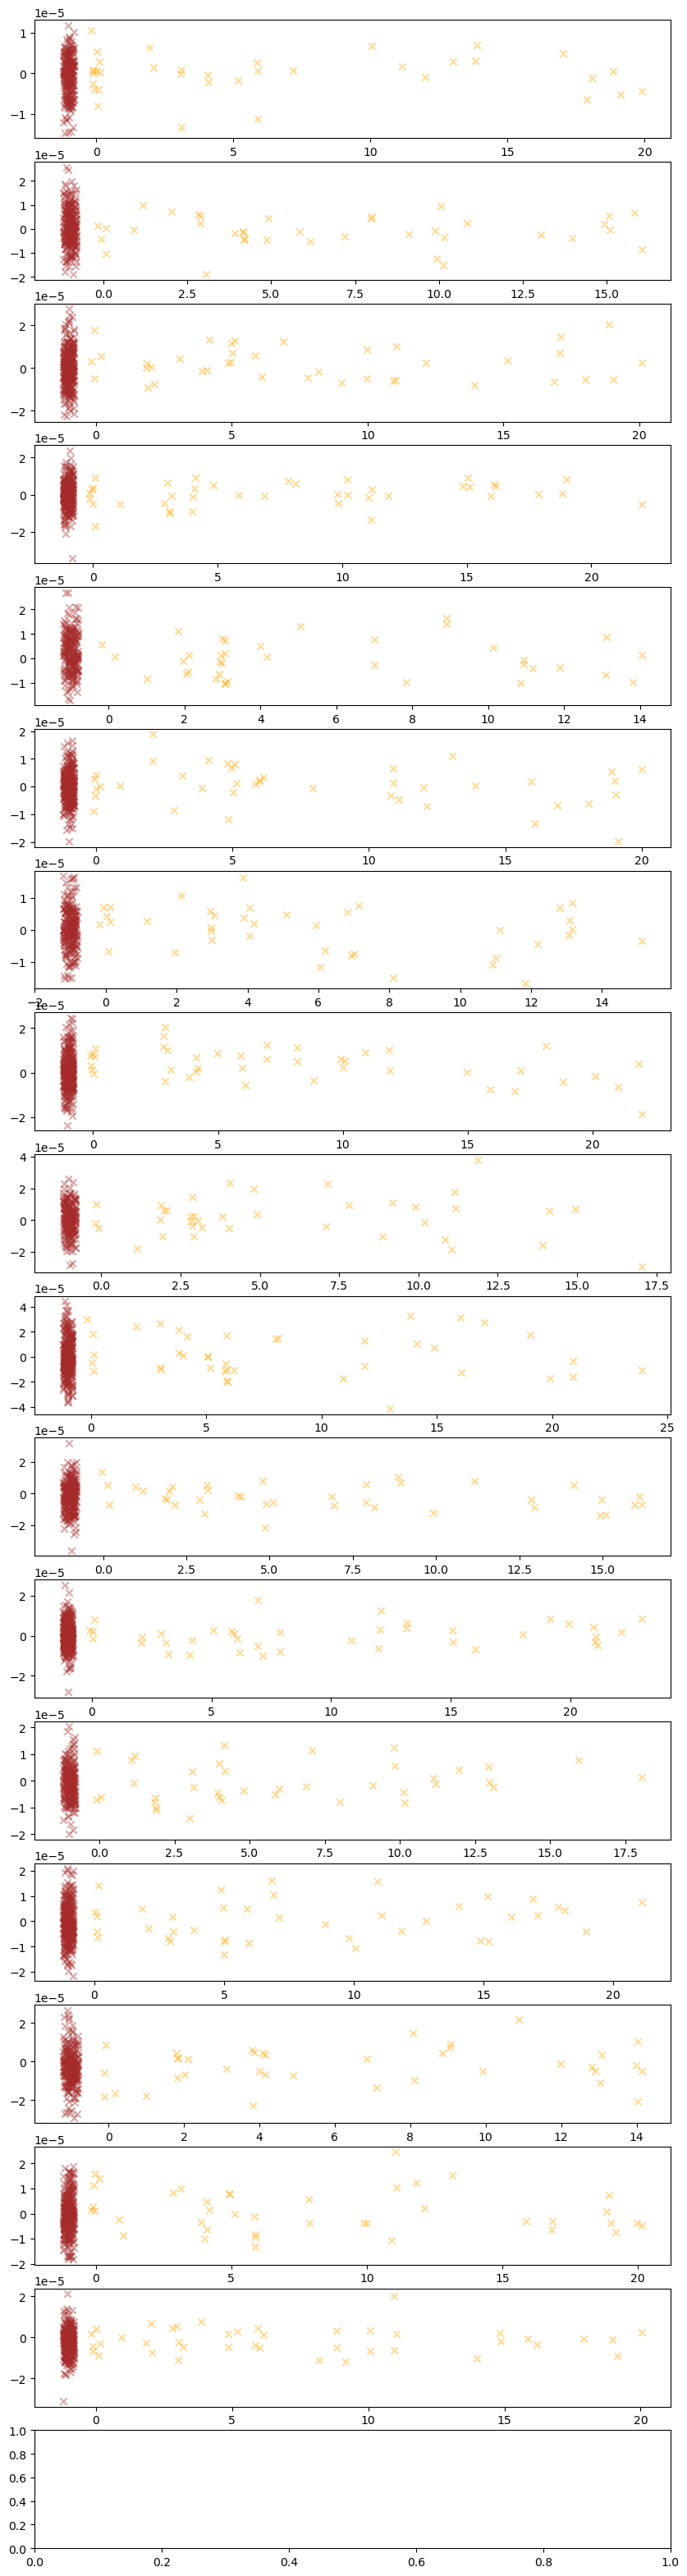

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

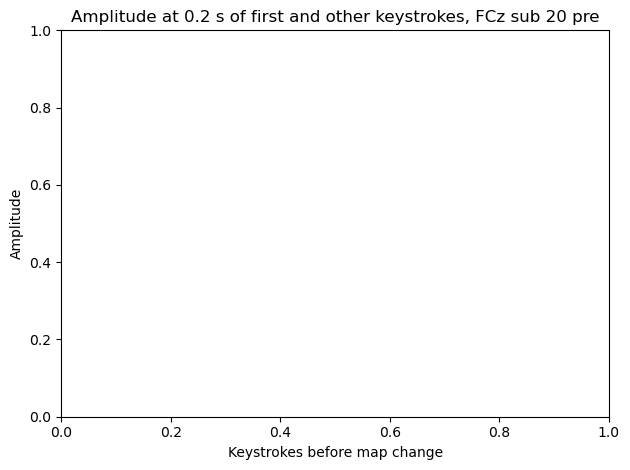

In [ ]:
"""good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects

#17 post has a shorter length

period = 'pre'
ch_to_plot = 'FCz'
ch_idx = ch_index([ch_to_plot])[0]

time_to_plot = 0.2
time_idx = time_index([time_to_plot])[0]

ep_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz'
mapchange_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv'

fig, axes = plt.subplots(18, 1, figsize = (10,40))
#for k, sub in enumerate([s for s in subjects_to_process if s != '04']):
for k, sub in enumerate([s for s in subjects_to_process if s != '04']):

    print(sub)
    #read epochs data
    ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
    eps = mne.read_epochs(ep_file).get_data()

    #read mapchange data
    mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
    mapchange_df = pd.read_csv(mapchange_file)
    mapchange_df_firsts = mapchange_df.query('type =="first"')
    mapchange_df_others = mapchange_df.query('type =="other"')

    print(mapchange_df.shape, eps.shape)

    plt.figure()
    for i, row in mapchange_df_firsts.iterrows():
        keystroke_idx = row['keystroke_idx']
        jitter_x = row['prev_keystrokes'] + np.random.uniform(-0.2, 0.2)
        #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'orange', marker = 'x', alpha = 0.4)
        axes[k].scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'orange', marker = 'x', alpha = 0.4)



    for i, row in mapchange_df_others.iterrows():
        keystroke_idx = row['keystroke_idx']
        jitter_x = -1 + np.random.uniform(-0.2, 0.2)
        #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'brown', marker = 'x', alpha = 0.4)
        axes[k].scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'brown', marker = 'x', alpha = 0.4)
  

#plt.hlines(0,0,max(mapchange_df_firsts['prev_keystrokes']), color = 'black')
plt.ylabel('Amplitude')
plt.xlabel('Keystrokes before map change')
plt.title(f'Amplitude at {time_to_plot} s of first and other keystrokes, {ch_to_plot} sub {sub} {period}')
plt.tight_layout()"""

## Difference within subjects

In [103]:
mne.set_log_level('CRITICAL')
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects
print(subjects_to_process)

['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


### Prev keystroke differences

In [104]:
time_to_plot = [0.08, 0.12]
#time_to_plot = [0.1]
time_idx = time_index_custom(time_to_plot, erp_times)

ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']
#ch_to_plot = ['FCz']
ch_idx = ch_index(ch_to_plot)


periods = ['pre', 'post']

data_f = []
data_o = []

col = 'orange'
for k, sub in enumerate(subjects_to_process):
    for period in periods:

        # Read epochs data
        ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
        eps = mne.read_epochs(ep_file).get_data()

        # Read mapchange data
        mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
        mapchange_df = pd.read_csv(mapchange_file)
        mapchange_df_firsts = mapchange_df.query('type =="first"')
        mapchange_df_others = mapchange_df.query('type =="other"')


        #add to dataframe for the first keystrokes
        for i, row in mapchange_df_firsts.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                prev_keystrokes = row['prev_keystrokes']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx]) #include multiple channels and single timepoint
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]]) #include multiple timepoint and single channel
                amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1)) #include multiple time points and multiple channels
                data_f.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'first',
                    'prev_keystrokes': prev_keystrokes,
                    'amp_f': amp
                })
                
                

            except IndexError: 
                print(f'Index error in first keystrokes for {sub}')
                continue
            
        for i, row in mapchange_df_others.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]])
                amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1))
                data_o.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'other',
                    'prev_keystrokes': -1,
                    'amp_o': amp
                    })
                
            
            except IndexError:
                print(f'Index error in other keystrokes for {sub}')
                continue 

f_df = pd.DataFrame(data_f)
o_df = pd.DataFrame(data_o)

Index error in other keystrokes for 04
Index error in other keystrokes for 17


In [105]:
# get average erp for others 
periods =['pre', 'post']
data_o_ave = []
for sub in subjects_to_process:
    for period in periods:
        o_df_sub = o_df.query(f'subject == "{sub}" and period == "{period}"')
        aveamp = o_df_sub['amp_o'].mean()
    
        data_o_ave.append(
            {'subject': sub,
            'period': period,
            'aveamp_o': aveamp}
        )

data_o_ave = pd.DataFrame(data_o_ave)

In [106]:
#subtract average of all others from each first ERP 
df_diff = pd.merge(f_df, data_o_ave, on=['subject', 'period'])
df_diff['diff'] = df_diff['amp_f']-df_diff['aveamp_o']

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Difference amplitude - ave amplitude of others')

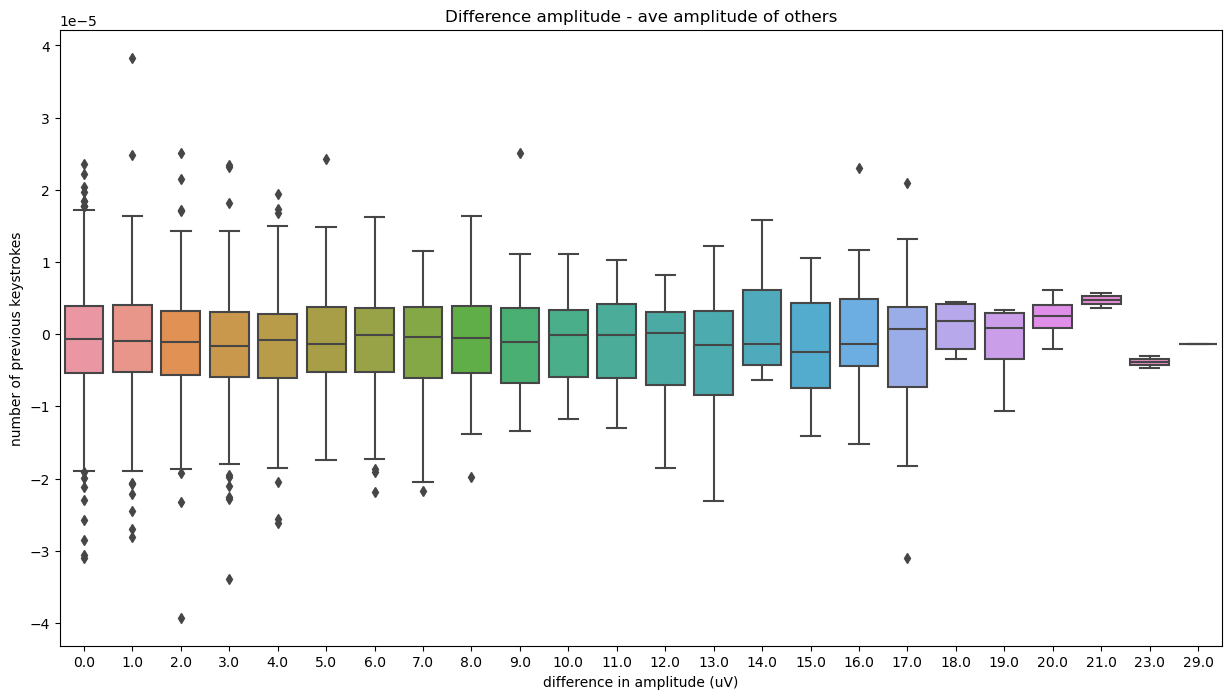

In [107]:
plt.figure(figsize=(15,8))
#sns.boxplot(data = df_diff[df_diff['period'] == 'post'], x = 'prev_keystrokes', y = 'diff')
sns.boxplot(data = df_diff, x = 'prev_keystrokes', y = 'diff')
plt.xlabel('difference in amplitude (uV)')
plt.xlabel('difference in amplitude (uV)')
plt.ylabel('number of previous keystrokes')
plt.title('Difference amplitude - ave amplitude of others')

In [228]:
# # Get the first 4 unique values of 'prev_keystrokes'
# first_4 = [0,1,2,3]

# # Filter the data
# df_filtered = df_diff[df_diff['prev_keystrokes'].isin(first_4)]

# # Plot
# sns.barplot(data=df_filtered, x='prev_keystrokes', y='diff', estimator = 'mean')

# plt.ylabel('Difference in amplitude (uV)')
# plt.xlabel('Number of previous keystrokes')
# plt.title('Difference amplitude - ave amplitude of others')

# plt.show()

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_43608/4127584192.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(data=df_filtered, x='prev_keystrokes', y='diff', estimator=np.mean, ci=95)
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depre

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Custom statistical test, P_val:6.063e-01
0.0 vs. 2.0: Custom statistical test, P_val:2.191e-01
0.0 vs. 3.0: Custom statistical test, P_val:2.715e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 0.0: Custom statistical test, P_val:5.255e-03
1.0 vs. 1.0: Custom statistical test, P_val:1.707e-04
2.0 vs. 2.0: Custom statistical test, P_val:6.295e-04
3.0 vs. 3.0: Custom statistical test, P_val:9.087e-07


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

<Figure size 800x600 with 0 Axes>

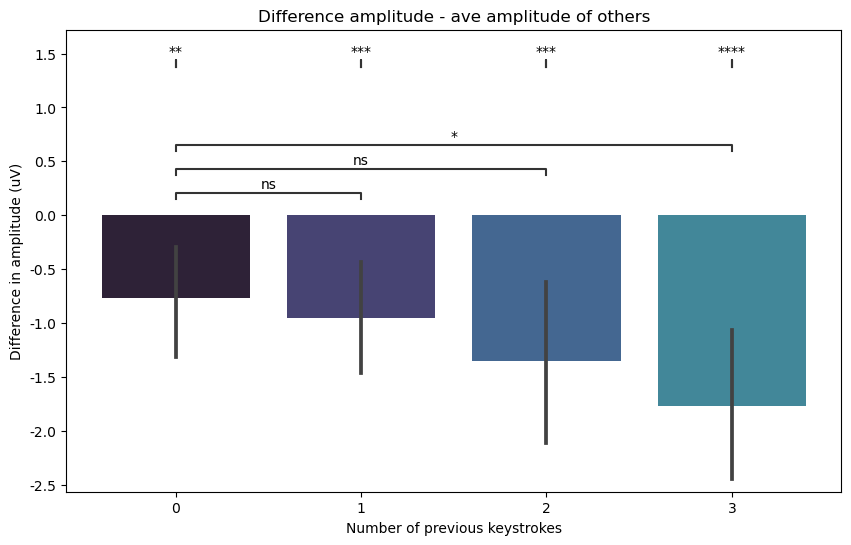

In [109]:

from statannotations.Annotator import Annotator
import itertools


sns.set_palette("mako") 
plt.figure(figsize =(8, 6))

# Get the first 4 unique values of 'prev_keystrokes'
first_4 = [0, 1, 2, 3]
df_filtered = df_diff[df_diff['prev_keystrokes'].isin(first_4)]


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_filtered, x='prev_keystrokes', y='diff', estimator=np.mean, ci=95)


# annotate pairwise diffs
# Define pairwise comparisons
pairs = [(0, 1), (0, 2), (0, 3)]
#pairwise stats
p_values_dict = {pair: stats.ttest_ind(df_filtered[df_filtered['prev_keystrokes'] == pair[0]]['diff'],
                                  df_filtered[df_filtered['prev_keystrokes'] == pair[1]]['diff']).pvalue 
            for pair in pairs}

annotator = Annotator(ax, pairs, data=df_filtered, x='prev_keystrokes', y='diff')
p_values = list(p_values_dict.values())
annotator.set_pvalues(p_values)
annotator.annotate()

#annotate diff from 0
# Define pairs for each level of 'prev_keystrokes' against 0
pairs = [(n_keystroke, n_keystroke) for n_keystroke in first_4]

# Initialize Annotator with the pairs
annotator_1samp = Annotator(ax, pairs, data=df_filtered, x='prev_keystrokes', y='diff')
#annotator_1samp.configure(loc ='outside')

p_values_1samp = []
for n_keystroke in first_4:
    group_data = df_filtered[df_filtered['prev_keystrokes'] == n_keystroke]['diff']
    t_stat, p_val = stats.ttest_1samp(group_data, 0)
    p_values_1samp.append(p_val)
annotator_1samp.set_pvalues(p_values_1samp)

annotator_1samp.annotate(line_offset_to_group=0.4)



plt.ylabel('Difference in amplitude (uV)')
plt.xlabel('Number of previous keystrokes')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV

plt.title('Difference amplitude - ave amplitude of others')
plt.xticks([0, 1, 2, 3], labels = [int(x) for x in [0, 1, 2, 3]]) 
plt.show()


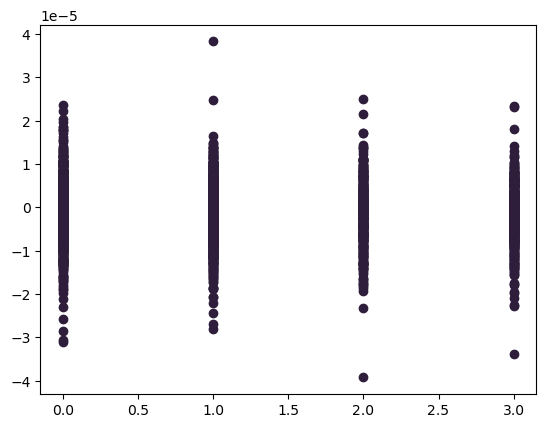

In [232]:
plt.scatter(df_filtered['prev_keystrokes'], df_filtered['diff'])

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 1.0, "['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2'], pre, min 0.08-1.2s")

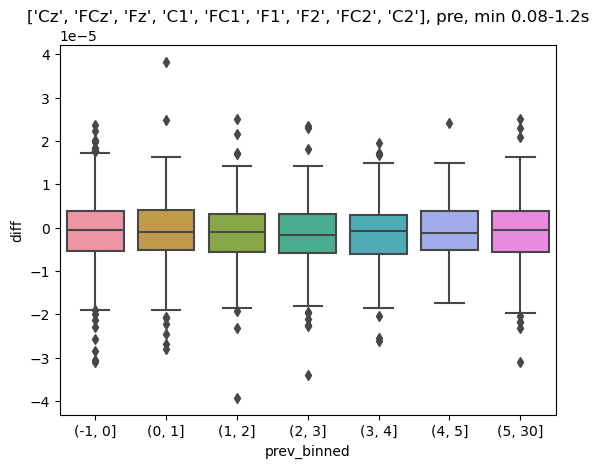

In [111]:
period = 'pre'

df_diff['prev_binned'] = pd.cut(df_diff['prev_keystrokes'], [-1,0,1,2,3,4,5,30])
sns.boxplot(data=df_diff, x = 'prev_binned', y = 'diff')
#sns.violinplot(data=df_diff[df_diff['period']==period], x = 'prev_binned', y = 'diff')
#plt.ylim(-6e-6,6e-6)
plt.title(f'{ch_to_plot}, {period}, min 0.08-1.2s')

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 1.0, "['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2'], pre, min 0.08-1.2s")

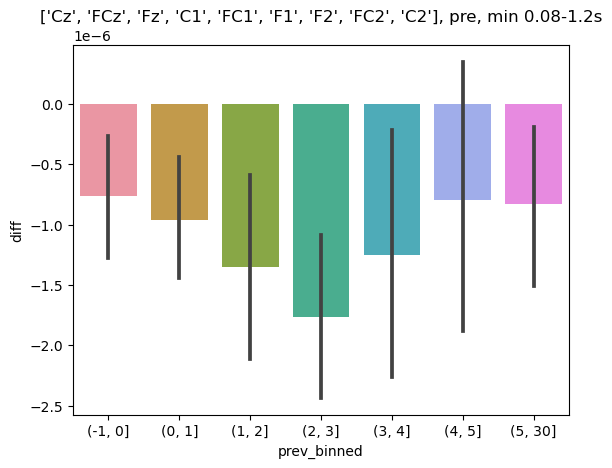

In [112]:
period = 'pre'

df_diff['prev_binned'] = pd.cut(df_diff['prev_keystrokes'], [-1,0,1,2,3,4,5,30])
sns.barplot(data=df_diff, x = 'prev_binned', y = 'diff')
#sns.boxplot(data=df_diff, x = 'prev_binned', y = 'diff')

#sns.violinplot(data=df_diff[df_diff['period']==period], x = 'prev_binned', y = 'diff')
#plt.ylim(-6e-6,6e-6)
plt.title(f'{ch_to_plot}, {period}, min 0.08-1.2s')

Stats on prev keystroke differences

In [113]:
for i in range(10):
    df_diff_sub = df_diff[df_diff['prev_keystrokes']==i]['diff'].values
    print(df_diff_sub.shape)

    

(729,)
(768,)
(361,)
(397,)
(219,)
(141,)
(104,)
(69,)
(57,)
(43,)


In [118]:
#multiple comparisons
ps = []
firsts_0 = df_diff[df_diff['prev_keystrokes']==0]['diff'].values

for i in range(1, 4):
    firsts_i = df_diff[df_diff['prev_keystrokes']==i]['diff'].values
    _, p = stats.ttest_ind(firsts_0, firsts_i)
    ps.append(p)


ps_corr = fdrcorrection(ps)
print('uncorrected p', ps)
print('corrected p', ps_corr)

uncorrected p [0.6062890815736343, 0.21911010763816252, 0.02715236737554926]
corrected p (array([False, False, False]), array([0.60628908, 0.32866516, 0.0814571 ]))


### Keystrokes since mapchange differences

In [122]:
time_to_plot = [0.08, 0.12]
#time_to_plot = [0.1]
time_idx = time_index_custom(time_to_plot, erp_times)

ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']
#ch_to_plot = ['FCz']
ch_idx = ch_index(ch_to_plot)


periods = ['pre', 'post']

data_o = []

for k, sub in enumerate(subjects_to_process):
    for period in periods:

        # Read epochs data
        ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
        eps = mne.read_epochs(ep_file).get_data()

        # Read mapchange data
        mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
        mapchange_df = pd.read_csv(mapchange_file)
        mapchange_df_others = mapchange_df.query('type =="other"')

            
        for i, row in mapchange_df_others.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                keystrokes_since = row['keystrokes_since']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]])
                amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1))
                data_o.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'other',
                    'keystrokes_since': keystrokes_since,
                    'amp_o': amp
                    })
                
            
            except IndexError:
                print(f'Index error in other keystrokes for {sub}')
                continue 

o_df_since = pd.DataFrame(data_o)

Index error in other keystrokes for 04
Index error in other keystrokes for 17


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(-1e-05, 1e-05)

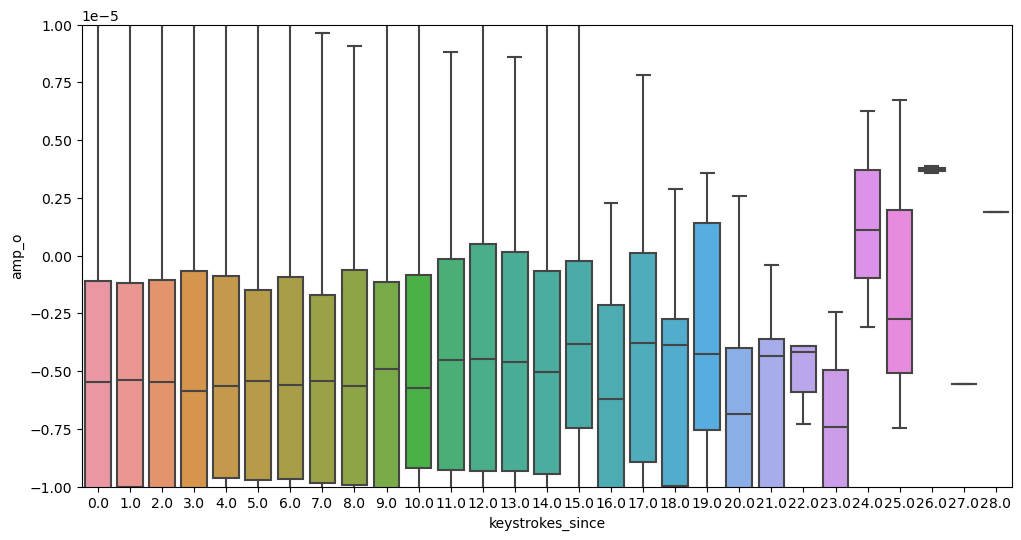

In [137]:
plt.figure(figsize = (12, 6))
sns.boxplot(data = o_df_since, x = 'keystrokes_since', y = 'amp_o')
plt.ylim(-1e-5, 1e-5)

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Amplitude of other keystrokes after map change')

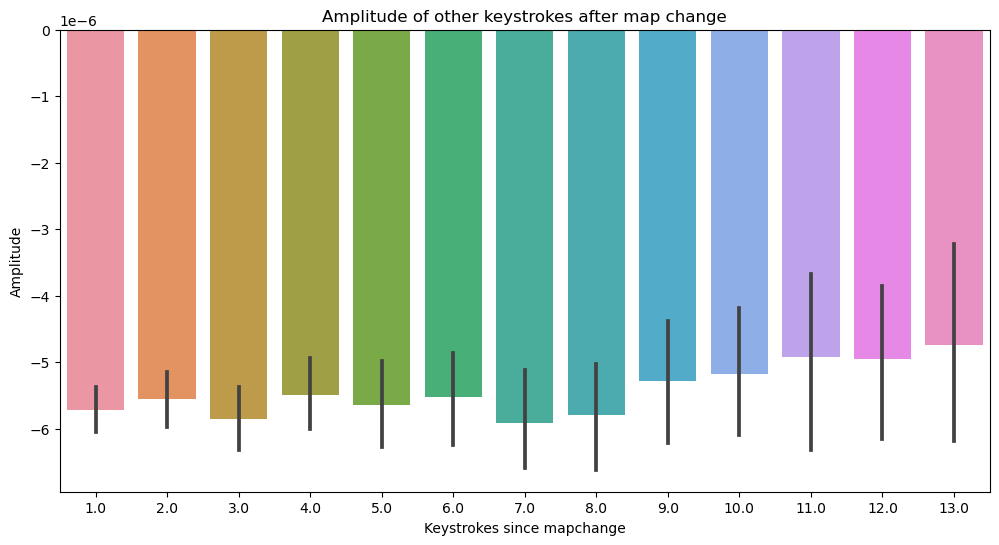

In [243]:
plt.figure(figsize = (12,6))
first_few = [1,2,3,4, 5,6, 7, 8, 9, 10, 11, 12, 13]
o_df_since_filt = o_df_since[o_df_since['keystrokes_since'].isin(first_few)]
sns.barplot(o_df_since_filt, x = 'keystrokes_since', y = 'amp_o')
plt.ylabel('Amplitude')
plt.xlabel('Keystrokes since mapchange')
plt.title('Amplitude of other keystrokes after map change')

PearsonRResult(statistic=0.023105753344833887, pvalue=0.02557101797877927)


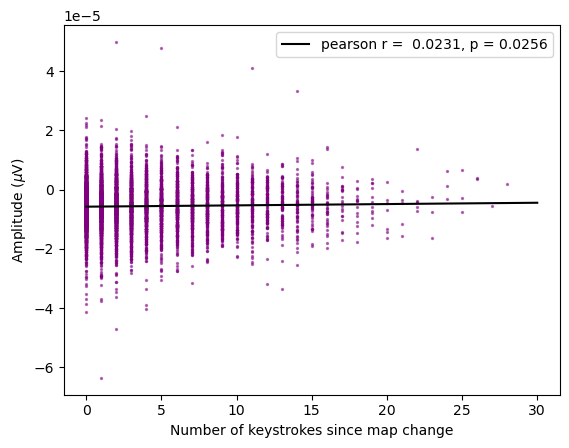

In [237]:
plt.scatter(o_df_since['keystrokes_since'], o_df_since['amp_o'], s = 2, color = 'purple', alpha = 0.5)
pearsonres = pearsonr(o_df_since['keystrokes_since'], o_df_since['amp_o'])
print(pearsonres)
#m, b, r, p, _, _ = stats.linregress(o_df_since['keystrokes_since'], o_df_since['amp_o'])
res = stats.linregress(o_df_since['keystrokes_since'], o_df_since['amp_o'])

x = np.linspace(0, 30, 100)
y = res.slope*x + res.intercept

plt.plot(x, y, label = f'pearson r = {pearsonres.statistic: .4f}, p ={pearsonres.pvalue: .4f}', color = 'black')
plt.ylabel('Amplitude ($\mu$V)')
plt.xlabel('Number of keystrokes since map change')
plt.legend()

In [189]:

from scipy.stats import bootstrap

def pearson_bootstrap(x, y, n_boot=10000):
    boot_corrs = []
    for _ in range(n_boot):
        idx = np.random.choice(len(x), size=len(x), replace=True)
        boot_corrs.append(pearsonr(x[idx], y[idx])[0])
    return np.percentile(boot_corrs, [2.5, 97.5])  # 95% CI

ci_pearson = pearson_bootstrap(o_df_since['keystrokes_since'].values, o_df_since['amp_o'].values)
print(f"Pearson correlation CI: {ci_pearson}")


Pearson correlation CI: [0.00350123 0.04276195]


In [179]:
# for value in np.unique(o_df_since['keystrokes_since'].values):
#     print( o_df_since['keystrokes_since'].value_counts())

In [195]:
o_df_since['since_binned'].values

[(0, 1], (1, 2], (2, 4], (2, 4], (-1, 0], ..., (8, 11], (8, 11], (8, 11], (11, 16], (11, 16]]
Length: 9337
Categories (9, interval[int64, right]): [(-1, 0] < (0, 1] < (1, 2] < (2, 4] ... (6, 8] < (8, 11] < (11, 16] < (16, 30]]

In [216]:



o_df_since

,subject,period,epochtype,keystrokes_since,amp_o,since_binned,since_binned_fl
0,01,pre,other,1.0,-1.316270e-05,"(0, 1]",1
1,01,pre,other,2.0,-6.111893e-06,"(1, 2]",2
2,01,pre,other,3.0,-1.081440e-05,"(2, 4]",4
3,01,pre,other,4.0,2.270302e-07,"(2, 4]",4
4,01,pre,other,0.0,-2.664724e-06,"(-1, 0]",0
...,...,...,...,...,...,...,...
9332,20,post,other,9.0,-5.124669e-06,"(6, 9]",9
9333,20,post,other,10.0,5.114366e-07,"(9, 12]",12
9334,20,post,other,11.0,3.061271e-06,"(9, 12]",12
9335,20,post,other,12.0,1.657948e-06,"(9, 12]",12


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-c

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-1 vs. 1: Custom statistical test, P_val:7.936e-01
-1 vs. 2: Custom statistical test, P_val:7.123e-01
-1 vs. 4: Custom statistical test, P_val:9.511e-01
-1 vs. 6: Custom statistical test, P_val:7.623e-01
-1 vs. 9: Custom statistical test, P_val:1.206e-01
-1 vs. 12: Custom statistical test, P_val:1.185e-01


(<Axes: title={'center': "['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2'], post, min 0.08-1.2s"}, xlabel='since_binned_fl', ylabel='amp_o'>,
  <statannotations.Annotation.Annotation at 0x153bdb0d0>])

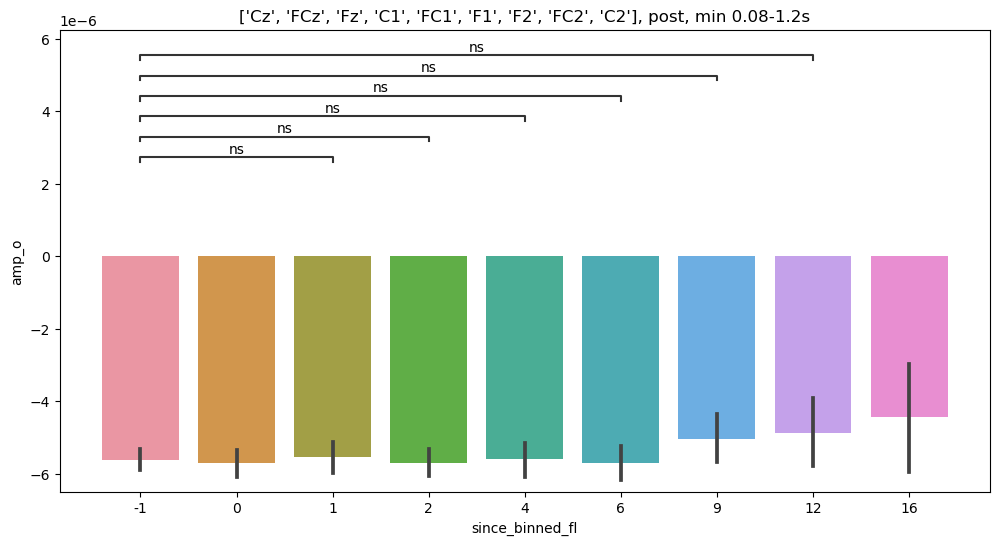

In [221]:
o_df_since['since_binned'] = pd.cut(o_df_since['keystrokes_since'], [-1,0,1,2,4,6,9,12, 16, 30])
o_df_since['since_binned_fl'] = o_df_since['since_binned'].apply(lambda x: x.left)

plt.figure(figsize = (12,6))
ax = sns.barplot(data=o_df_since, x = 'since_binned_fl', y = 'amp_o')
#sns.violinplot(data=df_diff[df_diff['period']==period], x = 'prev_binned', y = 'diff')
#plt.ylim(-6e-6,6e-6)
plt.title(f'{ch_to_plot}, {period}, min 0.08-1.2s')


# #pairs = [(0, 1), (0, 2), (0, 3), (0,4), (0,5), (0,6), (0,7),(0, 10), (0,12)]

# #pairwise stats


pairs = [
    (-1,1), (-1,2), (-1,4), (-1,6), (-1,9), (-1,12)
]
p_values_dict = {pair: stats.ttest_ind(o_df_since[o_df_since['since_binned_fl'] == pair[0]]['amp_o'],
                                  o_df_since[o_df_since['since_binned_fl'] == pair[1]]['amp_o']).pvalue 
            for pair in pairs}



annotator_o = Annotator(ax, pairs, data=o_df_since, x='since_binned_fl', y='amp_o')
p_values = list(p_values_dict.values())
annotator_o.set_pvalues(p_values)
annotator_o.annotate(line_offset_to_group=0.4)

In [199]:
p_values_dict

{(Interval(0, 1, closed='right'), Interval(1, 2, closed='right')): nan,
 (Interval(1, 2, closed='right'), Interval(2, 4, closed='right')): nan,
 (Interval(2, 4, closed='right'), Interval(2, 4, closed='right')): nan,
 (Interval(-1, 0, closed='right'), Interval(0, 1, closed='right')): nan}